In [1]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler # Z-score variables
from sklearn.preprocessing import MinMaxScaler # Min-Max Normalization

from sklearn.model_selection import train_test_split # simple TT split cv

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

import os
import numpy as np
from scipy.interpolate import BSpline, make_interp_spline

Overview: Plots two strokes at the origin of the same figure

Details:
    - Currently only works with unimanual right controller strokes.
        - Test data: Sub 16 Sess 2 & 3 for pan down
    - Only traces the first trial.
    - Only plots the right controller's data points.

Requirements: 
    - Must edit variables 'path1' and 'path2' to your own path of two data files


In [41]:
#Removes rows where none of the triggers are being pulled and all trials that are not the specified trial
def drop_df(df, trial_num):
    df.drop(df[(df['trigger_pull_amount_left'] == 0) & (df['trigger_pull_amount_right'] == 0)].index, inplace=True)
    df.drop(df[(df['gesture_counter_UI']) != trial_num].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

#Edit here
path1 = '../Data/cleaned_session_F_PanDown_subjID_16_06-15-23_10-53-50.csv'
path2 = '../Data/cleaned_session_F_PanDown_subjID_16_06-20-23_10-46-47.csv'

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

drop_df(df1, 1)
drop_df(df2, 1)

fig = go.Figure()

#List of X, Y, Z points that make up the original strokes.
x_original_1 = np.array(df1['r_controller_translation_x'])
y_original_1 = np.array(df1['r_controller_translation_y'])
z_original_1 = np.array(df1['r_controller_translation_z'])
x_original_2 = np.array(df2['r_controller_translation_x'])
y_original_2 = np.array(df2['r_controller_translation_y'])
z_original_2 = np.array(df2['r_controller_translation_z'])

'''Smoothing the curve'''
# The number of control points and knots
k = 3  # degree of the B-spline
t1 = np.linspace(0, 1, len(x_original_1))
t2 = np.linspace(0, 1, len(x_original_2))

# Create the B-spline representation for each dimension
spl_x1 = make_interp_spline(t1, x_original_1, k=k)
spl_y1 = make_interp_spline(t1, y_original_1, k=k)
spl_z1 = make_interp_spline(t1, z_original_1, k=k)
spl_x2 = make_interp_spline(t2, x_original_2, k=k)
spl_y2 = make_interp_spline(t2, y_original_2, k=k)
spl_z2 = make_interp_spline(t2, z_original_2, k=k)

# Evaluate the B-spline over a dense set of points for a smooth trajectory
dense_t1 = np.linspace(0, 1, 5 * len(x_original_1))  # points in the smoothed curve; can be adjusted
dense_t2 = np.linspace(0, 1, 5 * len(x_original_2))

#List of all points on smoothed curve (5 * original length)
x_smoothed_1 = spl_x1(dense_t1)
y_smoothed_1 = spl_y1(dense_t1)
z_smoothed_1 = spl_z1(dense_t1)
x_smoothed_2 = spl_x2(dense_t2)
y_smoothed_2 = spl_y2(dense_t2)
z_smoothed_2 = spl_z2(dense_t2)


'''Extracting 50 points from the smoothed curve, which contains five times the original length'''
x_fifty_smoothed_1 = []
y_fifty_smoothed_1 = []
z_fifty_smoothed_1 = []
x_fifty_smoothed_2 = []
y_fifty_smoothed_2 = []
z_fifty_smoothed_2 = []

#Get 50 points from the original smoothed curve data point list and add it to the above

#You can delete this part later but I'm just commenting this so the code makes more sense.
#Each list has a different number of data points so to get 50 data points from each list 
#that are about equidistant from each other, you divide the total length (on average, smoothed 
#curve has about 250) by 50, which gets you the distance between each data point,
#hence distance_between_pts variable. So you collect every nth data point which will get you about 50.
#The if statements are just to ensure that there are 50 data points.
dist_between_pts = len(x_smoothed_1) / 50
curr_index = 0.0
for index in range(len(x_smoothed_1)):
    if dist_between_pts <= 0:
        continue
    if (index != int(curr_index)) :
        continue
    if len(x_fifty_smoothed_1) == 50:
        continue
    x_fifty_smoothed_1.append(x_smoothed_1[index])
    y_fifty_smoothed_1.append(y_smoothed_1[index])
    z_fifty_smoothed_1.append(z_smoothed_1[index])
    curr_index += dist_between_pts

dist_between_pts = len(x_smoothed_2) / 50
curr_index = 0.0
for index in range(len(x_smoothed_2)):
    if dist_between_pts <= 0:
        continue
    if (index != int(curr_index)) :
        continue
    if len(x_fifty_smoothed_2) == 50:
        continue
    x_fifty_smoothed_2.append(x_smoothed_2[index])
    y_fifty_smoothed_2.append(y_smoothed_2[index])
    z_fifty_smoothed_2.append(z_smoothed_2[index])
    curr_index += dist_between_pts

'''Moving the strokes the origin based on bounding box'''
#Calculate bounding box for centering
center1 = ((np.max(x_fifty_smoothed_1) + np.min(x_fifty_smoothed_1))/2, 
           (np.max(y_fifty_smoothed_1) + np.min(y_fifty_smoothed_1))/2, 
           (np.max(z_fifty_smoothed_1) + np.min(z_fifty_smoothed_1))/2)
center2 = ((np.max(x_fifty_smoothed_2) + np.min(x_fifty_smoothed_2))/2, 
           (np.max(y_fifty_smoothed_2) + np.min(y_fifty_smoothed_2))/2, 
           (np.max(z_fifty_smoothed_2) + np.min(z_fifty_smoothed_2))/2)

#List of 50 points on smoothed curve centered at the origin
x_centered_smooth_1 = [val - center1[0] for val in x_fifty_smoothed_1]
y_centered_smooth_1 = [val - center1[1] for val in y_fifty_smoothed_1]
z_centered_smooth_1 = [val - center1[2] for val in z_fifty_smoothed_1]
x_centered_smooth_2 = [val - center2[0] for val in x_fifty_smoothed_2]
y_centered_smooth_2 = [val - center2[1] for val in y_fifty_smoothed_2]
z_centered_smooth_2 = [val - center2[2] for val in z_fifty_smoothed_2]


'''Plotting the strokes on the figures'''
# Draw traces
fig.add_trace(go.Scatter3d(
    x = x_centered_smooth_1,
    y = y_centered_smooth_1,
    z = z_centered_smooth_1,
    mode='markers',
    marker=dict(
        size=2,
        colorscale='sunset_r',  # colorscale
        opacity=0.8,
    ),
    name='Sub 16 Sess 2',
    showlegend=True)
)
fig.add_trace(go.Scatter3d(
    x = x_centered_smooth_2,
    y = y_centered_smooth_2,
    z = z_centered_smooth_2,
    mode='markers',
    marker=dict(
        size=2,
        colorscale='viridis',  # colorscale
        opacity=0.8,
    ),
    name='Sub 16 Sess 3',
    showlegend=True)
)
fig.update_layout(
    title_text='Pan Down (Right Unimanual)', 
    scene_aspectmode='data'
)
fig.show()


In [42]:
# variables with 50 points
x_centered_smooth_1
y_centered_smooth_1
z_centered_smooth_1
x_centered_smooth_2
y_centered_smooth_2
z_centered_smooth_2

# https://www.geeksforgeeks.org/python-difference-two-lists/#

fifty_points_dict = {
                        "x1": x_centered_smooth_1,
                        "y1": y_centered_smooth_1,
                        "z1": z_centered_smooth_1,
    
                        "x2": x_centered_smooth_2,
                        "y2": y_centered_smooth_2,
                        "z2": z_centered_smooth_2,
                    }
shapeDF = pd.DataFrame(data=fifty_points_dict)
arcLengthDF = pd.DataFrame(data=fifty_points_dict) # Initialize it early

shapeDF["x_diff"] = shapeDF["x1"] - shapeDF["x2"]
shapeDF["y_diff"] = shapeDF["y1"] - shapeDF["y2"]
shapeDF["z_diff"] = shapeDF["z1"] - shapeDF["z2"]

# shapeDF["norm"] = math.sqrt((shapeDF["x_diff"]**2) + (shapeDF["y_diff"]**2) + (shapeDF["z_diff"]**2))
shapeDF["norm"] = np.sqrt((shapeDF["x_diff"]**2) + (shapeDF["y_diff"]**2) + (shapeDF["z_diff"]**2))

# shapeDF

In [45]:
# Shape Error
def calculateShapeError(shapeDF):
    ShE = (1/len(shapeDF)) * sum(shapeDF["norm"])
    ShE

    # Shape Variabiltiy
    ShV = np.sqrt( (1/(len(shapeDF)-1)) * sum(shapeDF["norm"] - ShE**2))
    ShV

    print(f"Shape Error: {ShE}")
    print(f"Shape Variability: {ShV}")
calculateShapeError(shapeDF)

Shape Error: 0.06454957269432524
Shape Variability: 0.24822415264932365


In [58]:
import math

def fibonacci_sphere(samples=50, radius=1):

    points = []
    phi = math.pi * (math.sqrt(5.) - 1.)  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points

r3_sphere = fibonacci_sphere(samples=50, radius=3)
r5_sphere = fibonacci_sphere(samples=50, radius=5)
# r5_sphere

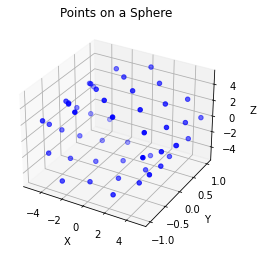

None
Shape Error: 2.0
Shape Variability: nan


In [59]:
# Extract x, y, and z coordinates for plotting
r3_x, r3_y, r3_z = zip(*r3_sphere)
r5_x, r5_y, r5_z = zip(*r5_sphere)


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
# ax.scatter(r3_x, r3_y, r3_z, c='b', marker='o')
ax.scatter(r5_x, r5_y, r5_z, c='b', marker='o')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot title
plt.title('Points on a Sphere')

# Show the plot
print(plt.show())


fifty_points_dict = {
                        "x1": r3_x,
                        "y1": r3_y,
                        "z1": r3_z,
    
                        "x2": r5_x,
                        "y2": r5_y,
                        "z2": r5_z,
                    }
sphereArcLengthDF = pd.DataFrame(data=fifty_points_dict) # For later calculation. Initilize here
shapeDF2 = pd.DataFrame(data=fifty_points_dict)

shapeDF2["x_diff"] = shapeDF2["x1"] - shapeDF2["x2"]
shapeDF2["y_diff"] = shapeDF2["y1"] - shapeDF2["y2"]
shapeDF2["z_diff"] = shapeDF2["z1"] - shapeDF2["z2"]

# shapeDF["norm"] = math.sqrt((shapeDF["x_diff"]**2) + (shapeDF["y_diff"]**2) + (shapeDF["z_diff"]**2))
shapeDF2["norm"] = np.sqrt((shapeDF2["x_diff"]**2) + (shapeDF2["y_diff"]**2) + (shapeDF2["z_diff"]**2))
shapeDF2


calculateShapeError(shapeDF2)

In [10]:
sphereArcLengthDF

,x1,y1,z1,x2,y2,z2
0,3.000000,1.000000,0.000000,5.000000,1.000000,0.000000
1,-2.212107,0.959184,-2.026471,-3.686844,0.959184,-3.377451
2,0.262277,0.918367,2.988513,0.437129,0.918367,4.980855
3,1.825317,0.877551,-2.380802,3.042194,0.877551,-3.968004
4,-2.954140,0.836735,0.522546,-4.923567,0.836735,0.870910
5,2.531266,0.795918,1.610184,4.218776,0.795918,2.683640
6,-0.778813,0.755102,-2.897145,-1.298022,0.755102,-4.828575
7,-1.382721,0.714286,2.662345,-2.304535,0.714286,4.437242
8,2.817964,0.673469,-1.029116,4.696606,0.673469,-1.715193
9,-2.773037,0.632653,-1.144669,-4.621728,0.632653,-1.907782


In [30]:
def calculateSphereArcLength():
    p0_arc_length = []
    p1_arc_length = []
    
    for i in range(1, len(sphereArcLengthDF)+1):
        p0_inner_val = 0
        p1_inner_val = 0
        
        for j in range(1, i):
            p0_x_diff = sphereArcLengthDF.iloc[j]["x1"] - sphereArcLengthDF.iloc[j-1]["x1"]
            p0_y_diff = sphereArcLengthDF.iloc[j]["y1"] - sphereArcLengthDF.iloc[j-1]["y1"]
            p0_z_diff = sphereArcLengthDF.iloc[j]["z1"] - sphereArcLengthDF.iloc[j-1]["z1"]
            
            p0_norm = np.sqrt((p0_x_diff**2) + (p0_y_diff**2) + (p0_z_diff**2))
            p0_inner_val += p0_norm
            
            
            p1_x_diff = sphereArcLengthDF.iloc[j]["x2"] - sphereArcLengthDF.iloc[j-1]["x2"]
            p1_y_diff = sphereArcLengthDF.iloc[j]["y2"] - sphereArcLengthDF.iloc[j-1]["y2"]
            p1_z_diff = sphereArcLengthDF.iloc[j]["z2"] - sphereArcLengthDF.iloc[j-1]["z2"]
            p1_norm = np.sqrt((p1_x_diff**2) + (p1_y_diff**2) + (p1_z_diff**2))
            p1_inner_val += p1_norm
    
        p0_arc_length.append(p0_inner_val)
        p1_arc_length.append(p1_inner_val)
        
    sphereArcLengthDF["x1_arc_length"] = p0_arc_length
    sphereArcLengthDF["x2_arc_length"] = p1_arc_length

calculateSphereArcLength()

# 2nd LE Formula
pathLength1 = sphereArcLengthDF.iloc[len(sphereArcLengthDF)-1]["x1_arc_length"] # Last index of the dataframe since we just want the total distance
pathLength2 = sphereArcLengthDF.iloc[len(sphereArcLengthDF)-1]["x2_arc_length"]

# Print arc-length - should be 2*pi*r for 360 degree 
print(f"Sphere Arc Length 1: {pathLength1}")
print(f"Sphere Arc Length 2: {pathLength2}")



LE = np.absolute(pathLength1 - pathLength2)
print(f"Length Error: {LE}")

sphereArcLengthDF


Sphere Arc Length 1: 274.02483130692525
Sphere Arc Length 2: 456.7002669293095
Length Error: 182.67543562238427


,x1,y1,z1,x2,y2,z2,x1_arc_length,x2_arc_length
0,3.000000,1.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000
1,-2.212107,0.959184,-2.026471,-3.686844,0.959184,-3.377451,5.592343,9.320414
2,0.262277,0.918367,2.988513,0.437129,0.918367,4.980855,11.184687,18.640827
3,1.825317,0.877551,-2.380802,3.042194,0.877551,-3.968004,16.777030,27.961241
4,-2.954140,0.836735,0.522546,-4.923567,0.836735,0.870910,22.369374,37.281654
5,2.531266,0.795918,1.610184,4.218776,0.795918,2.683640,27.961717,46.602068
6,-0.778813,0.755102,-2.897145,-1.298022,0.755102,-4.828575,33.554061,55.922482
7,-1.382721,0.714286,2.662345,-2.304535,0.714286,4.437242,39.146404,65.242895
8,2.817964,0.673469,-1.029116,4.696606,0.673469,-1.715193,44.738748,74.563309
9,-2.773037,0.632653,-1.144669,-4.621728,0.632653,-1.907782,50.331091,83.883722


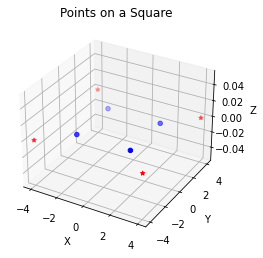

In [60]:
largeSquare = [(-4,4,0), (4,4,0), (4,-4,0), (-4,-4,0)]
smallSquare = [(-2,2,0), (2,2,0), (2,-2,0), (-2,-2,0)]


l_x, l_y, l_z = zip(*largeSquare)
s_x, s_y, s_z = zip(*smallSquare)


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(s_x, s_y, s_z, c='b', marker='o')
ax.scatter(l_x, l_y, l_z, c='r', marker='*')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot title
plt.title('Points on a Square')

# Show the plot
plt.show()

In [83]:
points_dict = {
                        "x1": l_x,
                        "y1": l_y,
                        "z1": l_z,
    
                        "x2": s_x,
                        "y2": s_y,
                        "z2": s_z,
                    }
squareArcLengthDF = pd.DataFrame(data=points_dict) # For later calculation. Initilize here



def calculateArcLength(arcLengthDF):
    p0_arc_length = []
    p1_arc_length = []
    
    for i in range(1, len(arcLengthDF)+1): # range 1-5, iterates 4 times
        p0_inner_val = 0 # Sum of norms for p0
        p1_inner_val = 0 # Sum of norms for p1
        
        for j in range(1, i): # range 1 to i (1-4). Inner for loop takes the abs difference of both points
            p0_x_diff = arcLengthDF.iloc[j]["x1"] - arcLengthDF.iloc[j-1]["x1"]
            p0_y_diff = arcLengthDF.iloc[j]["y1"] - arcLengthDF.iloc[j-1]["y1"]
            p0_z_diff = arcLengthDF.iloc[j]["z1"] - arcLengthDF.iloc[j-1]["z1"]
            p0_norm = np.sqrt((p0_x_diff**2) + (p0_y_diff**2) + (p0_z_diff**2))
            p0_inner_val += p0_norm
            
            
            p1_x_diff = arcLengthDF.iloc[j]["x2"] - arcLengthDF.iloc[j-1]["x2"]
            p1_y_diff = arcLengthDF.iloc[j]["y2"] - arcLengthDF.iloc[j-1]["y2"]
            p1_z_diff = arcLengthDF.iloc[j]["z2"] - arcLengthDF.iloc[j-1]["z2"]
            p1_norm = np.sqrt((p1_x_diff**2) + (p1_y_diff**2) + (p1_z_diff**2))
            p1_inner_val += p1_norm
    
        p0_arc_length.append(p0_inner_val)
        p1_arc_length.append(p1_inner_val)
        
    arcLengthDF["x1_arc_length"] = p0_arc_length
    arcLengthDF["x2_arc_length"] = p1_arc_length

calculateArcLength(squareArcLengthDF)


def calculateLengthError(arcLengthDF):
# 2nd LE Formula
    pathLength1 = arcLengthDF.iloc[len(arcLengthDF)-1]["x1_arc_length"] # Last index of the dataframe since we just want the total distance
    pathLength2 = arcLengthDF.iloc[len(arcLengthDF)-1]["x2_arc_length"]

    # Print arc-length - should be 2*pi*r for 360 degree 
    print(f"Arc Length 1: {pathLength1}")
    print(f"Arc Length 2: {pathLength2}")

    LE = np.absolute(pathLength1 - pathLength2)
    print(f"Length Error: {LE}")


# Calculate arc length before calculating length error
calculateArcLength(squareArcLengthDF)
calculateLengthError(squareArcLengthDF)


squareArcLengthDF

Arc Length 1: 24.0
Arc Length 2: 12.0
Length Error: 12.0


,x1,y1,z1,x2,y2,z2,x1_arc_length,x2_arc_length
0,-4,4,0,-2,2,0,0.0,0.0
1,4,4,0,2,2,0,8.0,4.0
2,4,-4,0,2,-2,0,16.0,8.0
3,-4,-4,0,-2,-2,0,24.0,12.0


In [48]:
# Length Error Calculation
# arcLengthDF["arc_length_diff"] = np.absolute(arcLengthDF["x1_arc_length"] - arcLengthDF["x2_arc_length"])

# First LE formula
# LE = sum(arcLengthDF["arc_length_diff"])
# print(f"Length Error: {LE}")

# 2nd LE Formula
pathLength1 = arcLengthDF.iloc[len(arcLengthDF)-1]["x1_arc_length"]
pathLength2 = arcLengthDF.iloc[len(arcLengthDF)-1]["x2_arc_length"]

# Print arc-length
print(f"Arc Length 1: {pathLength1}")
print(f"Arc Length 2: {pathLength2}")



LE = np.absolute(pathLength1 - pathLength2)
print(f"Length Error: {LE}")

# Try triangle

Arc Length 1: 0.8742565702719274
Arc Length 2: 0.8342511894852337
Length Error: 0.04000538078669369


In [28]:
# Kinematic Accuracy
timeDF = arcLengthDF.copy() # Copy by value

# Calculating time error
# takes the difference, divides by 50 to get equaldistant points
df1_time_diff = df1.iloc[len(df1)-1]["time"] - df1.iloc[0]["time"]
df1_time_unit = df1_time_diff / 50 # create equidistant unit for each point
df1_time_points = [i* df1_time_unit for i in range(50)]

df2_time_diff = df2.iloc[len(df2)-1]["time"] - df2.iloc[0]["time"]
df2_time_unit = df2_time_diff / 50
df2_time_points = [i* df2_time_unit for i in range(50)]

timeDF["df1_time"] = df1_time_points
timeDF["df2_time"] = df2_time_points
df1_duration = timeDF.iloc[len(timeDF)-1]["df1_time"]
df2_duration = timeDF.iloc[len(timeDF)-1]["df2_time"]
timeError = abs(df1_duration - df2_duration)

# Calculating time variability
    # Calculate time difference (taking into account the time error) between the same row. Part of the for loop in Time Variability formula
timeDF["time_diff_with_TE"] = (abs(timeDF["df1_time"] - timeDF["df2_time"]) - timeError) ** 2
timeVariability = np.sqrt( (1/(len(timeDF)-1)) * sum(timeDF["time_diff_with_TE"]) )




# Print results
print(f"timeError: {timeError}")
print(f"Time Variability: {timeVariability}")

timeError: 0.17622833251947556
Time Variability: 0.10330149961765939


In [93]:
# test case for time error

time1_time_points = [i * 2 for i in range(4)] 
time2_time_points = [i * 4 for i in range(4)]

# Create Data frame for time
timeDF = squareArcLengthDF.copy() # Copy by value
timeDF["df1_time"] = time1_time_points
timeDF["df2_time"] = time2_time_points
# time_points_dict = {"df1_time": time1_time_points, "df2_time": time2_time_points}
# timeDF = pd.DataFrame(data=time_points_dict)



def calculateTimeError(timeDF):
    df1_duration = timeDF.iloc[len(timeDF)-1]["df1_time"] # duration = 6
    df2_duration = timeDF.iloc[len(timeDF)-1]["df2_time"] # duration = 12
    timeError = abs(df1_duration - df2_duration)
    
    timeDF["time_diff_with_TE"] = (abs(timeDF["df1_time"] - timeDF["df2_time"]) - timeError) ** 2
    timeVariability = np.sqrt( (1/(len(timeDF)-1)) * sum(timeDF["time_diff_with_TE"]) )
    
    print(f"timeError: {timeError}")
    print(f"Time Variability: {timeVariability}")

calculateTimeError(timeDF)
# print(timeDF)


def calculateSpeedError(timeDF):
    x1_speed = [0]
    x2_speed = [0]
    for i in range(len(timeDF)):
        if i == 0:
            continue
        x1_speed.append((timeDF.iloc[i]["x1_arc_length"] - timeDF.iloc[i-1]["x1_arc_length"]) / (timeDF.iloc[i]["df1_time"] - timeDF.iloc[i-1]["df1_time"]))
        x2_speed.append((timeDF.iloc[i]["x2_arc_length"] - timeDF.iloc[i-1]["x2_arc_length"]) / (timeDF.iloc[i]["df2_time"] - timeDF.iloc[i-1]["df2_time"]))

    timeDF["x1_speed"] = x1_speed
    timeDF["x2_speed"] = x2_speed
    timeDF["speed_diff"] = abs(timeDF["x1_speed"] - timeDF["x2_speed"])
    timeDF

    # Speed Error = VE
    VE = (1/len(timeDF)) * sum(timeDF["speed_diff"])
    
    # Speed Variability = VV
    timeDF["speed_diff_with_VE"] = (timeDF["speed_diff"] - VE)**2
    VV = np.sqrt( (1/len(timeDF)) * sum(timeDF["speed_diff_with_VE"]) )

    print(f"Speed Error: {VE}")
    print(f"Speed Variability: {VV}")

calculateSpeedError(timeDF)
timeDF
    

timeError: 6.0
Time Variability: 4.320493798938573
Speed Error: 2.25
Speed Variability: 1.299038105676658


,x1,y1,z1,x2,y2,z2,x1_arc_length,x2_arc_length,df1_time,df2_time,time_diff_with_TE,x1_speed,x2_speed,speed_diff,speed_diff_with_VE
0,-4,4,0,-2,2,0,0.0,0.0,0,0,36.0,0.0,0.0,0.0,5.0625
1,4,4,0,2,2,0,8.0,4.0,2,4,16.0,4.0,1.0,3.0,0.5625
2,4,-4,0,2,-2,0,16.0,8.0,4,8,4.0,4.0,1.0,3.0,0.5625
3,-4,-4,0,-2,-2,0,24.0,12.0,6,12,0.0,4.0,1.0,3.0,0.5625


In [ ]:
x1_speed = [0]
x2_speed = [0]
for i in range(len(timeDF)):
    if i == 0:
        continue
    x1_speed.append((timeDF.iloc[i]["x1_arc_length"] - timeDF.iloc[i-1]["x1_arc_length"]) / (timeDF.iloc[i]["df1_time"] - timeDF.iloc[i-1]["df1_time"]))
    x2_speed.append((timeDF.iloc[i]["x2_arc_length"] - timeDF.iloc[i-1]["x2_arc_length"]) / (timeDF.iloc[i]["df2_time"] - timeDF.iloc[i-1]["df2_time"]))
    
timeDF["x1_speed"] = x1_speed
timeDF["x2_speed"] = x2_speed
timeDF["speed_diff"] = abs(timeDF["x1_speed"] - timeDF["x2_speed"])
timeDF

# Speed Error = VE
VE = (1/len(timeDF)) * sum(timeDF["speed_diff"])


# Speed Variability = VV
timeDF["speed_diff_with_VE"] = (timeDF["speed_diff"] - VE)**2
VV = np.sqrt( (1/len(timeDF)) * sum(timeDF["speed_diff_with_VE"]) )

print(f"Speed Error: {VE}")
print(f"Speed Variability: {VV}")

In [65]:
# Size Error = SzE
fifty_points_dict = {
                        "x1": x_centered_smooth_1,
                        "y1": y_centered_smooth_1,
                        "z1": z_centered_smooth_1,
    
                        "x2": x_centered_smooth_2,
                        "y2": y_centered_smooth_2,
                        "z2": z_centered_smooth_2,
                    }
sizeDF = pd.DataFrame(data=fifty_points_dict)
sizeDF

x1_volume = (max(sizeDF["x1"]) - min(sizeDF["x1"])) * ((max(sizeDF["y1"]) - min(sizeDF["y1"]))) * (max(sizeDF["z1"]) - min(sizeDF["z1"]))
x2_volume = (max(sizeDF["x2"]) - min(sizeDF["x2"])) * ((max(sizeDF["y2"]) - min(sizeDF["y2"]))) * (max(sizeDF["z2"]) - min(sizeDF["z2"]))

SzE = abs(x1_volume - x2_volume)
print(f"x1_volume: {x1_volume}")
print(f"x2_volume: {x2_volume}")

print(f"Size Error: {SzE}")

x1_volume: 0.017263038146977192
x2_volume: 0.008476650348511795
Size Error: 0.008786387798465398


In [ ]:
# Bending Error
bendingDF = pd.DataFrame(data=fifty_points_dict)
bendingDF

p1_thetaArr = []
p2_thetaArr = []

# Reference for theta calculation: https://mathsathome.com/angle-between-two-vectors/
# https://saturncloud.io/blog/how-to-show-the-angle-between-two-3d-vectors-in-matplotlib-a-guide/

for i in range(len(bendingDF)):
    if i == 0 or i == len(bendingDF)-1:
        p1_thetaArr.append(0)
        p2_thetaArr.append(0)
        continue
    
    # For Gesture 1     
    p1_x1, p1_y1, p1_z1 = bendingDF.iloc[i-1]["x1"], bendingDF.iloc[i-1]["y1"], bendingDF.iloc[i-1]["z1"]
    p1_x2, p1_y2, p1_z2 = bendingDF.iloc[i+1]["x1"], bendingDF.iloc[i+1]["y1"], bendingDF.iloc[i+1]["z1"]
    p1_vector1, p1_vector2 = np.array([p1_x1, p1_y1, p1_z1]), np.array([p1_x2, p1_y2, p1_z2])
    
    p1_angle_rad = np.arccos(np.dot(p1_vector1, p1_vector2) / (np.linalg.norm(p1_vector1) * np.linalg.norm(p1_vector2)))
    p1_angle_deg = np.degrees(p1_angle_rad)
    p1_thetaArr.append(p1_angle_deg)
    
    # For Gesture 2
    p2_x1, p2_y1, p2_z1 = bendingDF.iloc[i-1]["x2"], bendingDF.iloc[i-1]["y2"], bendingDF.iloc[i-1]["z2"]
    p2_x2, p2_y2, p2_z2 = bendingDF.iloc[i+1]["x2"], bendingDF.iloc[i+1]["y2"], bendingDF.iloc[i+1]["z2"]
    p2_vector1, p2_vector2 = np.array([p2_x1, p2_y1, p2_z1]), np.array([p2_x2, p2_y2, p2_z2])
    
    p2_angle_rad = np.arccos(np.dot(p2_vector1, p2_vector2) / (np.linalg.norm(p2_vector1) * np.linalg.norm(p2_vector2)))
    p2_angle_deg = np.degrees(p2_angle_rad)
    p2_thetaArr.append(p2_angle_deg)
    

bendingDF["gesture_1_theta"] = p1_thetaArr
bendingDF["gesture_2_theta"] = p2_thetaArr
bendingDF

In [ ]:
# Bending Error = BE
bendingDF["theta_diff"] = abs(bendingDF["gesture_1_theta"] - bendingDF["gesture_2_theta"])
BE = (1/len(bendingDF)) * sum(bendingDF["theta_diff"])

# Bending Variability = BV
bendingDF["theta_diff_with_BE"] = (sum(bendingDF["theta_diff"]) - BE) ** 2
BV = np.sqrt( (1/len(bendingDF)-1) * sum(bendingDF["theta_diff_with_BE"]) )

print(f"Bending Error: {BE}")
print(f"Bending Variability: {BV}")